In [274]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append('./../../../../')
sys.path.append('./../../../script/')
sys.path.append('./')
sys.path.append('./designer/script/')

from tmm.get_E import get_E_free
from tmm.get_jacobi_arb_adjoint import get_jacobi_E_free_form
from tmm.get_jacobi_adjoint import get_jacobi_adjoint
from tmm.get_spectrum import get_spectrum_free
from film import FreeFormFilm

import numpy as np



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Manual differentiation

In [2]:

wls = np.linspace(500, 1000, 3)
inc_ang = 0.
np.random.seed(0)
film = FreeFormFilm(np.random.random(4) * 1 + 1.5, 1000, 1)
jacobian = np.zeros((wls.shape[0] * 4, film.get_d().shape[0], 2, 2), dtype='complex128')

get_jacobi_E_free_form(
    jacobian, wls, film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    inc_ang, 
)

E = np.zeros((wls.shape[0] * 2, 2), dtype='complex128')
get_E_free(E, wls, film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    inc_ang, 
)


jacobian_gt = np.zeros((wls.shape[0] * 2, film.get_d().shape[0]))
get_jacobi_adjoint(
    jacobian_gt, wls, film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    inc_ang, 
)


/home/vipuser/miniconda3/envs/tf_design/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/vipuser/miniconda3/envs/tf_design/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/vipuser/miniconda3/envs/tf_design/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [286]:
# autograd
from tmm.autograd_wrapper import *
from tmm.E_to_spectrum import E_to_R, E_to_tan2Psi

# set exp 
wls = np.linspace(500, 1000, 500)
inc_ang = 0.
np.random.seed(0)
film = FreeFormFilm(np.random.rand(20) * 1 + 1.5, 1000, 2)
d = film.get_d()
n_layers, n_sub, n_inc = film.calculate_n_array(wls), film.calculate_n_sub(wls), film.calculate_n_inc(wls)


# objective: 0.5
def loss_fn(E):
    e = E_to_R(E)
    dif = e - 0.5
    return dif.square().sum()

jacobi_auto = get_jacobi_warpper(loss_fn)
jacobi = np.zeros((wls.shape[0] * 4, d.shape[0], 2, 2))


em = jacobi_auto(    
    jacobi,
    wls,
    d,
    n_layers,
    n_sub,
    n_inc,
    inc_ang,    
)

E_gt = np.zeros((wls.shape[0] * 2, 2), dtype='complex128')
get_E_free(
    E_gt, 
    wls, 
    film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    inc_ang, 
)



In [306]:
# print(y_wrt_E) tested!
# M_wrt_x tested
# E_wrt_M, too

E = torch.tensor(E_gt, requires_grad=True, device='cuda')
jacobi_y_wrt_E = torch.autograd.grad(loss_fn(E), E)[0].t() # t for correct subsequent reshape

loss_old = loss_fn(torch.tensor(E_gt))
E_new = E_gt.copy()
E_new[0, 0] += 1e-5
loss_new = loss_fn(torch.tensor(E_new))
print((loss_new - loss_old) * 1e5)
print(jacobi_y_wrt_E[0, 0])

print((em * jacobi_y_wrt_E.reshape(-1, 1, 1, 1).conj()).sum((0, -1, -2)))

E_gt = np.zeros((wls.shape[0] * 2, 2), dtype='complex128')
get_E_free(
    E_gt, 
    wls, 
    film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    inc_ang, 
)
E_gt_n = np.zeros((wls.shape[0] * 2, 2), dtype='complex128')
d_old = film.get_d().copy()
d = d_old.copy()
d[0] += 1e-5
film.update_d(d)
get_E_free(
    E_gt_n, 
    wls, 
    film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    inc_ang, 
)
film.update_d(d_old)
print((E_gt_n - E_gt).sum(0) * 1e5)

print((loss_fn(torch.tensor(E_gt_n)) - loss_fn(torch.tensor(E_gt))) * 1e5)


tensor(0.0409, dtype=torch.float64)
tensor(0.0409+0.0594j, device='cuda:0', dtype=torch.complex128)
tensor([-0.0933+1.9877e+00j, -0.2249+2.1689e+00j, -0.2521+2.0183e+00j,
        -0.2721+1.9637e+00j, -0.2492+1.9251e+00j, -0.4360+2.1237e+00j,
        -0.3975+1.7071e+00j, -0.0777+1.9350e+00j, -0.1119+1.9562e+00j,
        -0.1076+1.3246e+00j, -0.1615+1.5216e+00j, -0.1407+1.2039e+00j,
        -0.1182+1.2150e+00j, -0.2945+1.1512e+00j,  0.0277+2.7800e-01j,
         0.0348+2.8819e-01j,  0.0028+2.9117e-01j,  0.0022-2.0322e-03j,
         0.0198-5.2249e-03j,  0.0265+1.2338e-02j], device='cuda:0',
       dtype=torch.complex128)
[-3.82765330e+00-2.22347675e+00j -3.77475828e-10-1.61676228e-09j]
tensor(-0.0933, dtype=torch.float64)


In [243]:
jacobian_gt = np.zeros((wls.shape[0] * 2, film.get_d().shape[0]))
get_jacobi_adjoint(
    jacobian_gt, wls, film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    inc_ang, 
)
spec_gt = np.zeros((wls.shape[0] * 2))
get_spectrum_free(
    spec_gt, 
    wls, 
    film.get_d(), 
    film.calculate_n_array(wls), 
    film.calculate_n_sub(wls), 
    film.calculate_n_inc(wls), 
    inc_ang, 
)
grad_gt = 8 * jacobian_gt[:wls.shape[0], :].T * (spec_gt[:wls.shape[0]] - 0.5)

print(grad_gt.sum(-1))

grad_diff = np.zeros(film.get_layer_number())
for i in range(film.get_layer_number()):
    d_original = film.get_d().copy()
    d = d_original.copy()
    d[i] += 1e-5
    film.update_d(d)
    spec_gt_var = np.zeros((wls.shape[0] * 2))
    get_spectrum_free(
        spec_gt_var, 
        wls, 
        film.get_d(), 
        film.calculate_n_array(wls), 
        film.calculate_n_sub(wls), 
        film.calculate_n_inc(wls), 
        inc_ang, 
    )
    film.update_d(d_original)
    grad_diff[i] = (np.square(spec_gt_var - 0.5).sum() - np.square(spec_gt - 0.5).sum()) / 1e-5
print(grad_diff)

print(-2 * jacobi)

[-0.18651694 -0.4498943  -0.50426269 -0.54413743 -0.49837391 -0.87196827
 -0.79494945 -0.15538778 -0.22385335 -0.21511829 -0.32309645 -0.28143111
 -0.23636326 -0.58895753  0.05537844  0.06955902  0.00564243  0.00432891
  0.03958944  0.05298165]
[-0.18651684 -0.44989419 -0.5042626  -0.54413735 -0.49837383 -0.87196819
 -0.79494941 -0.15538768 -0.22385325 -0.21511824 -0.32309643 -0.2814311
 -0.23636324 -0.58895747  0.05537848  0.06955906  0.00564246  0.0043289
  0.03958943  0.05298165]
tensor([-1.9258-1.2633j, -2.0027-1.4059j, -1.8568-1.3194j, -1.7499-1.3190j,
        -1.8022-1.3150j, -1.7779-1.7406j, -1.2350-1.4286j, -1.6534-0.9036j,
        -1.6112-0.9587j, -0.8901-0.5629j, -0.8722-0.6035j, -0.5447-0.4145j,
        -0.5661-0.3645j, -0.0153-0.5337j,  0.6192+0.4955j,  0.6076+0.5088j,
         0.5932+0.4157j,  1.5155+1.3733j,  1.4307+1.3913j,  1.3647+1.3701j],
       device='cuda:0', dtype=torch.complex128)


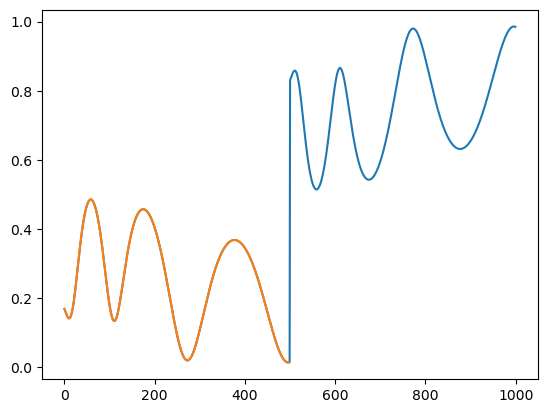

In [199]:
import matplotlib.pyplot as plt
plt.plot(spec_gt)
r = (E[:, 1] / E[:, 0]).abs().square().cpu().detach()
plt.plot(r[:wls.shape[0]] * 0.5 + r[wls.shape[0]:] * 0.5)